# Rubrique : rassembler, comparer
Afin de réduire la quantité de documents à analyser pour déterminer les lettres parlant d'un sujet identique, une solution consiste à ne rechercher que dans les rubriques (~ 211 en tout) susceptibles d'en contenir.


In [9]:
# Import
import spacy
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from collections import Counter
from random import sample
import seaborn as sns
import numpy as np
from scipy.spatial import distance
import word2vec

In [10]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

# A. Similarités entre rubriques
L'idée est de déterminer une mesure de similarité entre les rubriques.
## 1 Les noms des rubriques
Dans un premier temps, une mesure de la similarité de deux rubriques en ne considérant que leur nom peut-être suffisante. **Word embedding** semble être la meilleure solution, car ils portent l'information du **contexte** du mot, ce qui est précisément ce que nous cherchons ici.

## 1.1 Avec spacy : modèle préentraîné de CBOW
* La base de vecteurs utilisée :https://spacy.io/models/fr#fr_core_news_md
* Lien vers son origine : https://fasttext.cc/docs/en/unsupervised-tutorial.html#advanced-readers-skipgram-versus-cbow

In [11]:
# Import lemmatiseur
import fr_core_news_md
nlp = fr_core_news_md.load()

In [13]:
# Choisir le nombre de rubriques à essayer
NB_RUBRIQUES  = 10

# Ensemble aléatoire de rubriques
rubriques_sample = sample([i.split(' ')[0] for i in df.rubrique.unique()],NB_RUBRIQUES)

# Objets correspondants aux mots
doc = nlp(' '.join(rubriques_sample))

# Fonction de similarité entre deux mots d'indice i et j dans ruba
def comp(i,j):
    if i < j or rubriques_sample[i] == rubriques_sample[j]:
        return 0
    a = doc[i]
    b = doc[j]
    if a.has_vector and b.has_vector:
        return a.similarity(b)
    return None

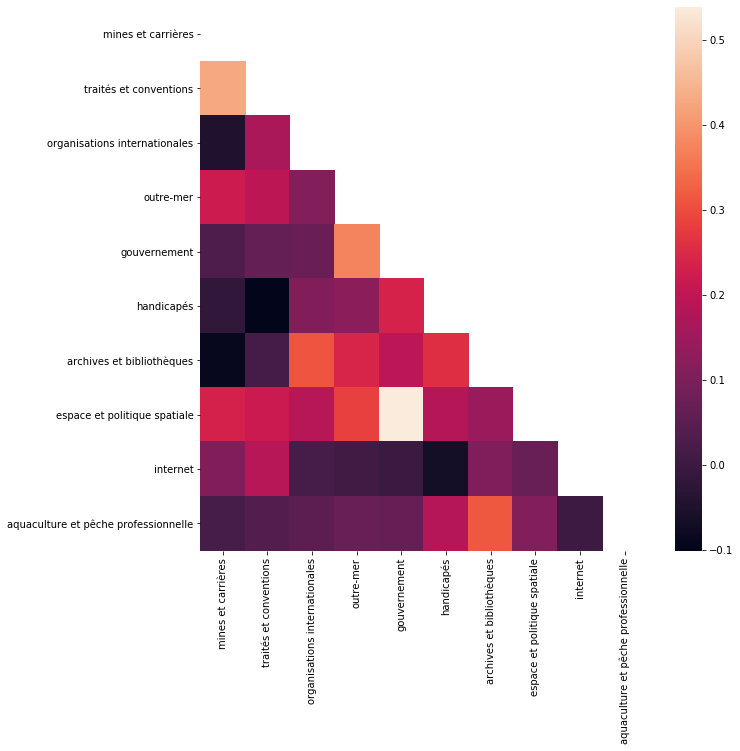

In [13]:
# Affichage de la matrice
mat = pd.DataFrame([[comp(i,j) for j in range(len(rubriques_sample))] for i in range(len(rubriques_sample))],columns = rubriques_sample, index = rubriques_sample)
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(mat)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(mat,ax = ax,mask=mask);

### 1.1.R Résultats de spacy :
* Souvent peu performants pour déterminer le contexte (profession emploi très bas, eau et contraception élevé)
* Assez lent et pas sommable

## 1.2 Word2Vec FrWac
Sur le site  https://fauconnier.github.io/#data, qui dispose d'un ensemble de corpus. Les données d'entrainement viennent de https://wacky.sslmit.unibo.it/doku.php?id=corpora. Le module Word2vec : https://github.com/danielfrg/word2vec . 

Mesure de similarité = cosine distance

In [5]:
# Load le model
model = word2vec.load('../data/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin')

In [8]:
# Nombre de rubriques à observer
NB_RUBRIQUES  = 10
# Sample aléatoire de rubriques
ruba = sample([i.lower() for i in df.rubrique.unique()],NB_RUBRIQUES)

In [16]:
# Fonctions de comparaison de similarité

# Prendre le premier mot
def first_mot(mot):
    return mot.split(' ')[0]

# Fonction de comparaison de distances de mots, en ne prenant que le premier
def comp_first(a,b):
    _,_,c =  model.distance(first_mot(a),first_mot(b))[0]
    return c

stops = {' ',':',"'",','}
# Fonction de comparaison de distances de mots, en faisant la moyenne des distances
def comp_mean(a,b):
    dists =  []
    for mota in a:
        if mota not in stops:
            for motb in b:
                 if motb not in stops:
                    _,_,c =  model.distance(mota,motb)[0]
                    dists.append(c)
    return sum(dists)/len(dists)

# Transforme un mot en vecteur, si il n'est pas reconnu on renvoit un vecteur de 0
def to_vec(mot,print_err = False):
    try : 
        return model[mot]
    except Exception as e:
        if print_err:
            print(type(e),e )
        return np.zeros(dim)
        
# Somme les vecteurs d'une phrase, si il y a un problème on retourne -1
def sum_we(phrase,print_err = True):
    try:
        return sum([ to_vec(mot)for mot in phrase.split(' ')])
    except Exception as e:
        if print_err:
            print(type(e),e )
        return -1

# Retourne la mesure de similarité : 1 - (distance des deux sommes de mots en vecteurs)
def sim_sum_vec(a,b):
    return 1 - distance.cosine(sum_we(a),sum_we(b))

### 1.2.1 Affichage Comp mean

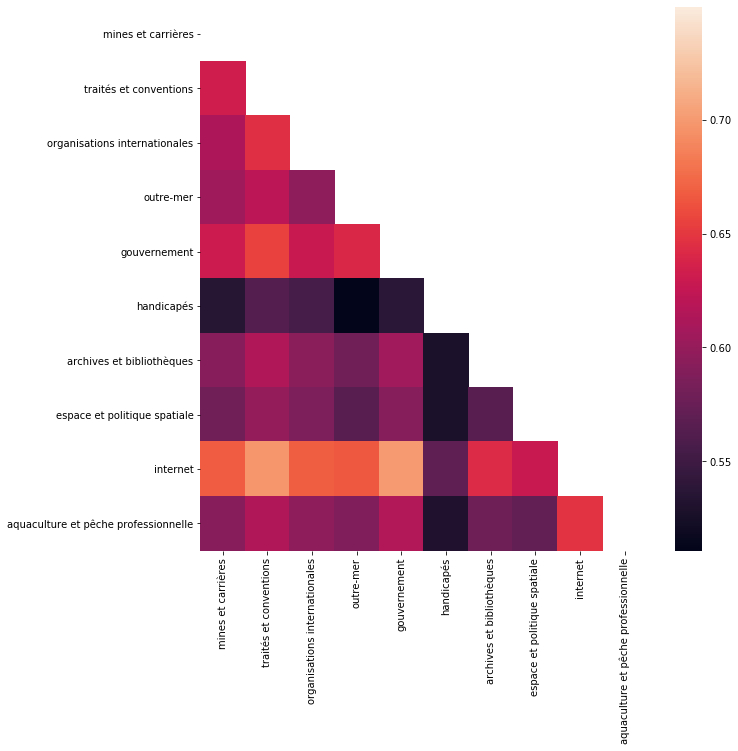

In [19]:
# Matrice des mots pour COMP_MEAN
mat = pd.DataFrame([[comp_mean(a,b) for b in ruba] for a in ruba],columns = ruba, index = ruba)

# Affichage
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(mat) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(mat,ax = ax,mask=mask);

### 1.2.1 Résultats comp mean   
* Model = CBOW, Dimension 200, cut = 100
On a des comparaisons de mots assez bonnes, mais qui n'indiquent pas forcément si deux rubriques peuvent avoir de sujets en commun. En revanche on peut comparer chaque mot d'un sujet pour être assez efficace.

**Attention** : 
* Ce n'est pas le moyen le plus efficace de calculer la matrice, distance(mot1,mot2,mot3,...) renvoie tout direct
* Normaliser le nom de rubriques pour éviter les pluriels etc. (*examens* passe pas) 

### 1.2.2 Affichage sim sum vec

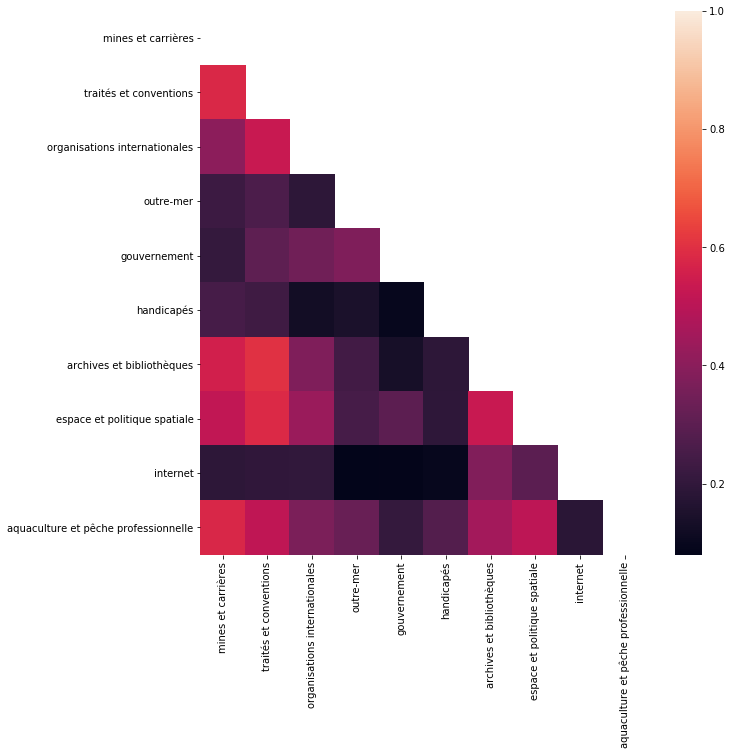

In [20]:
# Matrice des mots pour SIM_SUM_VEC
mat = pd.DataFrame([[sim_sum_vec(a,b) for b in ruba] for a in ruba],columns = ruba, index = ruba)

# Affichage
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(mat) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(mat,ax = ax,mask=mask);

### 1.2.2 Résultats sim sum vec
* Assez mitigé ...

# X. Idées
* Plutôt itérer sur tous les mots du sujet pour sélectionner les rubriques
* On entraîne un NN pour apprendre à reconnaître les rubriques en fonction du texte.